In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torchvision import io
from torchvision.models import resnet18, ResNet18_Weights

from torchvision.transforms import RandomHorizontalFlip, RandomRotation, RandomVerticalFlip, ColorJitter, RandomCrop


import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [3]:
output_dir = '/home/xuri/Загрузки/coffee-beans-project/coffee-beans/'
# определение пути
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'test')

In [4]:
transform = T.Compose([
                       T.ColorJitter(),
                       T.ToTensor(),
                       T.Resize((224, 224))
                       ])

# Создание датасетов
train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
val_dataset = torchvision.datasets.ImageFolder(val_dir, transform=transform)

# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [5]:
# Создание экземпляра модели ResNet
model = torchvision.models.resnet18(pretrained=True)

/home/xuri/ds_bootcamp/nn_project/env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xuri/ds_bootcamp/nn_project/env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [7]:
# Заменяем последний слой для задачи классификации кофе
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 4) # 4 класса кофе

# Проверяем последний слой
print(model.fc)

Linear(in_features=512, out_features=4, bias=True)


In [8]:
# Замораживаем все параметры, кроме классификационного слоя
for param in model.parameters():
    param.requires_grad = False
model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True 

In [9]:
# Проверка - всё гуд
for param in model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [10]:
# Оптимизатор и функция потерь
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [11]:

model = model.to(DEVICE)

In [12]:
def fit(
    model: nn.Module,
    n_epochs: int,
    optimizer: torch.optim.Optimizer,
    train_loader: DataLoader,
    valid_loader: DataLoader,
    history=None
) -> dict:

    # будем сохранять значения точности и лосса в history
    history = history or {
        'train_accs': [],
        'train_losses': [],
        'valid_accs': [],
        'valid_losses': [],
    }

    # определяем текущую эпоху обучения
    start_epoch = len(history['train_accs'])
    # запускаем цикл обучения
    for epoch in range(start_epoch+1, start_epoch+n_epochs+1):
        print(f'{"-"*13} Epoch {epoch} {"-"*13}')

        # перевод модели в режим обучения
        model.train()
        # инициализируем пустые списки для хранения результатов по батчам
        batch_accs = []
        batch_losses = []

        for images, labels in train_loader:
            # перенесем на девайс
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            preds = model(images)
            loss = criterion(preds, labels)
            accuracy = (preds.argmax(axis=1) == labels).cpu().numpy().mean()

            batch_losses.append(loss.item())
            batch_accs.append(accuracy)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        history['train_accs'].append(np.mean(batch_accs))
        history['train_losses'].append(np.mean(batch_losses))

        # перевод в режим валидации
        model.eval()
        batch_accs = []
        batch_losses = []

        for images, labels in valid_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            with torch.inference_mode():
                preds = model(images)

            loss = criterion(preds, labels)
            accuracy = (preds.argmax(axis=1) == labels).cpu().numpy().mean()

            batch_losses.append(loss.item())
            batch_accs.append(accuracy)

        history['valid_accs'].append(np.mean(batch_accs))
        history['valid_losses'].append(np.mean(batch_losses))

        # печатаем результат
        print(
            f'train: accuracy {history["train_accs"][-1]:.4f}, loss {history["train_losses"][-1]:.4f}\n'
            f'valid: accuracy {history["valid_accs"][-1]:.4f}, loss {history["valid_losses"][-1]:.4f}'
        )
        print(f'{"-"*35}')
        print()

    return history
    

In [14]:
logs = fit(model, 15, optimizer, train_loader, val_loader)

------------- Epoch 1 -------------
train: accuracy 0.9811, loss 0.1083
valid: accuracy 1.0000, loss 0.0628
-----------------------------------

------------- Epoch 2 -------------
train: accuracy 0.9827, loss 0.0979
valid: accuracy 0.9976, loss 0.0595
-----------------------------------

------------- Epoch 3 -------------
train: accuracy 0.9762, loss 0.0970
valid: accuracy 1.0000, loss 0.0531
-----------------------------------

------------- Epoch 4 -------------
train: accuracy 0.9844, loss 0.0862
valid: accuracy 1.0000, loss 0.0484
-----------------------------------

------------- Epoch 5 -------------
train: accuracy 0.9836, loss 0.0876
valid: accuracy 1.0000, loss 0.0455
-----------------------------------

------------- Epoch 6 -------------
train: accuracy 0.9729, loss 0.0943
valid: accuracy 0.9976, loss 0.0442
-----------------------------------

------------- Epoch 7 -------------
train: accuracy 0.9786, loss 0.0840
valid: accuracy 1.0000, loss 0.0383
----------------------

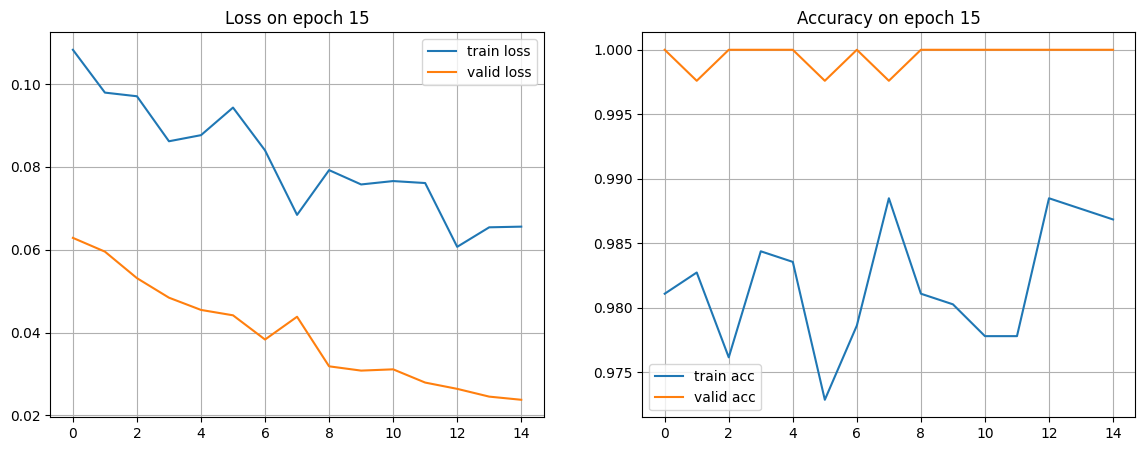

In [15]:
# зададим функцию рисования графиков
def plot_history(history, grid=True):
    fig, ax = plt.subplots(1,2, figsize=(14,5))
    
    ax[0].plot(history['train_losses'], label='train loss')
    ax[0].plot(history['valid_losses'], label='valid loss')
    ax[0].set_title(f'Loss on epoch {len(history["train_losses"])}')
    ax[0].grid(grid)
    ax[0].legend()
    
    ax[1].plot(history['train_accs'], label='train acc')
    ax[1].plot(history['valid_accs'], label='valid acc')
    ax[1].set_title(f'Accuracy on epoch {len(history["train_losses"])}')
    ax[1].grid(grid)
    ax[1].legend()
    
    plt.show()

plot_history(logs)

In [16]:
idx2class= {j: i for i, j in train_dataset.class_to_idx.items()}
idx2class

{0: 'Dark', 1: 'Green', 2: 'Light', 3: 'Medium'}

In [18]:
# Сохраняем модель
model_path = 'model_coffe.pth'
torch.save(model.state_dict(), model_path)
